# Tutorial

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from core.input import input_format
from core.astromer import get_ASTROMER, get_FINETUNING, train
from core.data  import (create_dataset, 
                        standardize,
                        load_records)

# This tutorial runs only in early mode. For the optimized code use train.py
tf.config.run_functions_eagerly(True)

%load_ext autoreload
%autoreload 2

In [2]:
source = './data/raw_data/MACHO/' # lightcurves folder
metadata = 'data/raw_data/MACHO/MACHO_dataset.dat' # metadata file
target = 'data/records/macho/' # where records will be stored

### Metadata frame sample

In [3]:
meta_sample = pd.read_csv(metadata).sample(1)
meta_sample

,Unnamed: 0,Class,N,Path,Band
793,793,EB,1112,LCs/lc_2_5515_159_B_mjd.dat,B


### Lightcurve frame sample

In [4]:
lc_df = pd.read_csv(os.path.join(source,  meta_sample['Path'].values[0]))
lc_df.head()

,mjd,mag,errmag
0,48823.668380,-6.209,0.031
1,48824.495451,-6.153,0.042
2,48825.513079,-6.162,0.028
3,48828.460231,-6.218,0.053
4,48829.467095,-6.108,0.024


### From .csv to .record 

In [5]:
# create_dataset(source, metadata, target, max_lcs_per_record=1000)

### Loading Data

In [6]:
# Loading data
batch_size = 10
input_len = 200
train_batches = load_records(os.path.join(target, 'train'), 
                             batch_size, 
                             input_len=input_len)
valid_batches = load_records(os.path.join(target, 'val'), 
                             batch_size, 
                             input_len=input_len)
test_batches = load_records(os.path.join(target, 'test'), 
                             batch_size, 
                             input_len=input_len)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


### Visualizing Records

In [7]:
input_len = 200 # maximum lightcurve length
batch_size = 256
dataset = load_records(target+'/train', batch_size=batch_size, input_len=input_len)

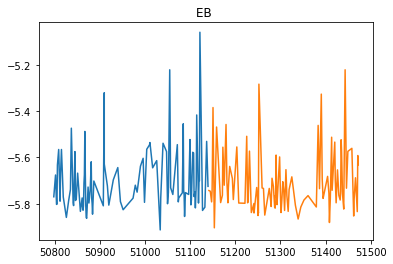

In [8]:
fig, axes = plt.subplots(1,1)
for batch in dataset:
    mask_1 = create_padding_mask(batch['serie_1'], batch['steps_1']-1)
    mask_2 = create_padding_mask(batch['serie_2'], batch['steps_2']-1)

    serie_1 = tf.boolean_mask(batch['serie_1'][n], tf.logical_not(mask_1[n]))
    serie_2 = tf.boolean_mask(batch['serie_2'][n], tf.logical_not(mask_2[n]))

    y = batch['label'][n]
    objects = pd.read_csv(os.path.join(target, 'objects.csv'))
    cls_label = objects.iloc[int(y)]['label']

    ax.plot(serie_1[:, 0], serie_1[:, 1])
    ax.plot(serie_2[:, 0], serie_2[:, 1])
    ax.set_title(cls_label+' '+title)
    break

## ASTROMER

### Input Layer

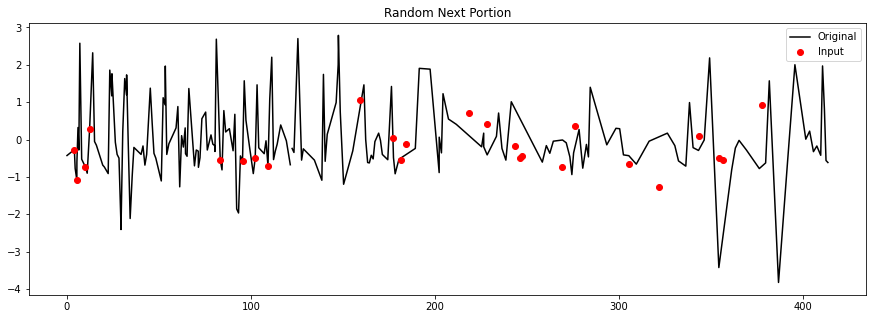

In [9]:
fig, axes = plt.subplots(1,1, figsize=(15,5))
for batch in dataset:
    n = 0
    inputs, targets = input_format(batch)
    
    magnitudes = inputs['values'][n][1:, 0]
    times = inputs['times'][n][1:, 0]
#     print(times)
    mask = targets['x_mask'][n]
    
    x = tf.boolean_mask(times, mask)
    y = tf.boolean_mask(magnitudes, mask)
    
    x_original = tf.slice(batch['serie_1'], [0,0,0],[-1,-1,1])
    x_original = x_original - tf.expand_dims(tf.reduce_min(x_original, 1), 2)
    y_original = tf.slice(batch['serie_1'], [0,0,1],[-1,-1,1])
    y_original = standardize(y_original)
    
    
    
    dt = [[[1.]]]# tf.expand_dims(tf.reduce_mean(x_original, 1), 2)
    last = tf.slice(x_original, [0,tf.shape(x_original)[1]-1,0], [-1, 1,-1])
    
    x_2_original = tf.slice(batch['serie_2'], [0,0,0],[-1,-1,1])
    x_2_original = x_2_original - tf.expand_dims(tf.reduce_min(x_2_original, 1), 2)
    x_2_original = x_2_original + last + dt
    
    y_2_original = tf.slice(batch['serie_2'], [0,0,1],[-1,-1,1])
    y_2_original = standardize(y_2_original)

    axes.plot(x_original[n], y_original[n], label='Original', color='black')
    axes.plot(x_2_original[n], y_2_original[n], color='black')
    axes.plot(x, y, linestyle='', marker='o',label='Input', color='red')
    axes.legend()
    
    if targets['y_true'][n][:, 0].numpy() == 1:
        title = 'Random Next Portion'
    else:
        title = 'No Next Random Portion'
    axes.set_title(title)
    break

# Training

In [10]:
astromer = get_ASTROMER()

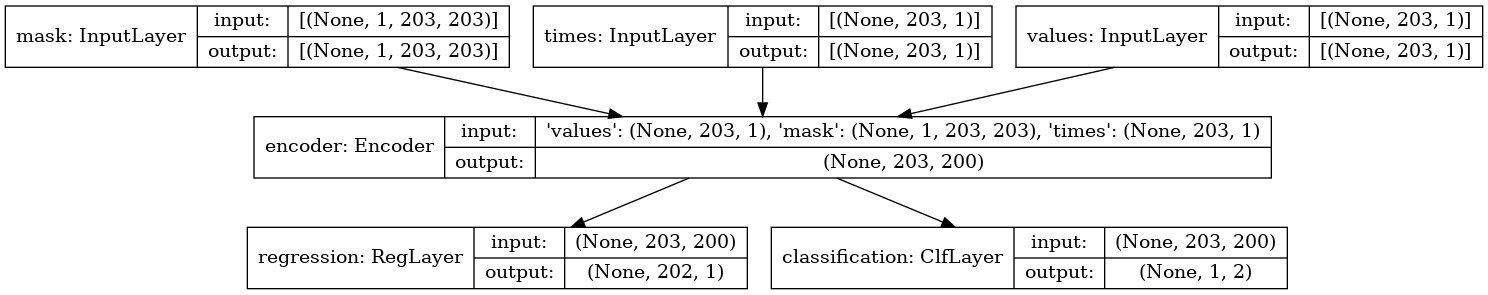

In [11]:
tf.keras.utils.plot_model(astromer, show_shapes=True)

In [ ]:
train(astromer, train_batches, valid_batches, epochs=2)

train: 315it [01:55,  2.73it/s]
validation: 157it [00:50,  3.12it/s]


tf.Tensor(94.8064, shape=(), dtype=float32)


train: 26it [00:11,  2.46it/s]

# FINETUNNING

In [ ]:
astromer = get_ASTROMER()

In [ ]:
astromer.load_weights('./experiments/test/weights')

In [ ]:
ft_model = get_FINETUNING(astromer, num_cls=10)

In [ ]:
tf.keras.utils.plot_model(ft_model, show_shapes=True)

In [ ]:
train(ft_model, train_batches, valid_batches, epochs=2, num_cls=10)